In [1]:
import findspark
findspark.init('/home/amir/Downloads/spark-2.3.0-bin-hadoop2.7')


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, DataFrame, SparkSession,Row
from pyspark.sql import functions as F

from pyspark.sql import functions as F
from pyspark.sql.types import StringType, TimestampType, DoubleType
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.window import Window


from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import xgboost as xgb
import shap
from bubble_plot.bubble_plot import bubble_plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.sql.types import *
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import OneHotEncoderEstimator,StringIndexer,FeatureHasher


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator

conf =SparkConf()
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
#spark.conf.set("spark.sql.session.timeZone", "America/New_York")
spark.conf.set("spark.sql.session.timeZone", "UTC")

sqlContext = SQLContext(sc)


/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
from random import randint,random
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.metrics import roc_curve, auc
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### read data, join, print schema.

In [17]:

table1 = sqlContext.read.parquet('/home/amir/Downloads/table_1.parquet')
table2 = sqlContext.read.parquet('/home/amir/Downloads/table_2.parquet')


df = table1.join(table2,on="id")

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- feature_1: string (nullable = true)
 |-- feature_2: string (nullable = true)
 |-- feature_3: string (nullable = true)
 |-- feature_4: string (nullable = true)
 |-- feature_5: string (nullable = true)
 |-- feature_6: string (nullable = true)
 |-- feature_7: string (nullable = true)
 |-- feature_8: string (nullable = true)
 |-- feature_9: string (nullable = true)
 |-- label: string (nullable = true)
 |-- feature_10: string (nullable = true)
 |-- feature_11: string (nullable = true)
 |-- feature_12: string (nullable = true)
 |-- feature_13: string (nullable = true)
 |-- feature_14: string (nullable = true)
 |-- feature_15: string (nullable = true)
 |-- feature_16: string (nullable = true)
 |-- feature_17: string (nullable = true)
 |-- feature_18: string (nullable = true)
 |-- feature_19: string (nullable = true)
 |-- feature_20: string (nullable = true)
 |-- feature_21: string (nullable = true)
 |-- feature_23: string (nullable = true)



### show 5 rows

In [6]:
df.limit(5).toPandas()

,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_23
0,10000894556194619153,14102513,8330,761,175,5ee41ff2192,ecad2386ff,07d7df22v8n,6f21a189eei7,0,...,7801e8d91e,07c4a65513p,23,1,17d996e64,3,320,f028772b7,a99f214ay39,50
1,100019328676614419983,14102417,17653,1994,39,5b08c53b192,ecad2386ff,07d7df22v8n,e24c8b65eei7,2,...,7801e8d91e,1fdd95db13p,33,1,7687a86e4,2,300,3e8141307,a99f214ay39,250
2,100022435335405777883,14102800,22677,2617,35,1fbe01fe192,ecad2386ff,07d7df22v8n,0eb711eceei7,0,...,7801e8d91e,48eabdc413p,51,1,f38457674,0,320,28905ebd7,a99f214ay39,50
3,100026024854859285833,14102315,15708,1722,35,1fbe01fe192,ecad2386ff,07d7df22v8n,f39b265eeei7,0,...,7801e8d91e,6d04613513p,79,1,f38457674,0,320,28905ebd7,a99f214ay39,50
4,100031088797340005593,14102808,21863,2524,35,85f751fd192,e9739828ff,cef3e649v8n,24f6b932eei7,0,...,df32afa91e,54196a1413p,221,1,c4e18dd64,0,320,50e219e07,a99f214ay39,50


In [7]:
df.select(F.min(F.col('feature_1').cast(IntegerType())).alias("min time"),
          F.max(F.col('feature_1').cast(IntegerType())).alias("max time")).show()

+--------+--------+
|min time|max time|
+--------+--------+
|14102100|14103023|
+--------+--------+



### we have data from the 21 to 30 of october 2014
create features for day and hour

In [18]:
df = df.withColumn('day',F.substring(F.col('feature_1'),5,2).cast(IntegerType()))
df = df.withColumn('hour',F.substring(F.col('feature_1'),7,2).cast(IntegerType()))
df.select('feature_1','day','hour').show(5)

+---------+---+----+
|feature_1|day|hour|
+---------+---+----+
| 14102513| 25|  13|
| 14102417| 24|  17|
| 14102800| 28|   0|
| 14102315| 23|  15|
| 14102808| 28|   8|
+---------+---+----+
only showing top 5 rows



### examine our target


In [9]:
df.groupBy('label').count().withColumn('percent',F.col('count')/df.count()).show()


+-----+-------+------------------+
|label|  count|           percent|
+-----+-------+------------------+
|    0|3354450|0.8302960472170621|
|    1| 685615|0.1697039527829379|
+-----+-------+------------------+



### how many values are "missing"?

In [10]:
df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_23,day,hour
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### looks like none nan values. 

### set string columns as ategorical, and the rest as numerical

In [19]:
cat_col = ['feature_5','feature_6','feature_7','feature_8',
       'feature_13','feature_14','feature_17',
       'feature_20','feature_21']

num_col = [c for c in df.columns if c not in cat_col+['label','id','feature_1']]

### cast to numeric type

In [20]:
for c in num_col+['label']:
    df = df.withColumn(c,F.col(c).cast(IntegerType()))

### check that we did not miss any column here

In [21]:
if (len(cat_col+num_col)+3) == len(df.columns):
    print("check")

check


### describe numeric columns

In [22]:
df.select(num_col).describe().toPandas()

,summary,feature_3,feature_4,feature_9,feature_11,feature_12,feature_15,feature_16,feature_18,feature_19,feature_23,day,hour
0,count,4040065,4040065,4040065,4040065,4040065,4040065,4040065,4040065,4040065,4040065,4040065,4040065
1,mean,2112.94267493221,227.26243043119356,0.331410261963607,0.288078285869163,53190.28914039749,83.40823303585462,1.0151435682346694,1.4322955199978218,318.8849120001782,60.06415886873107,25.46858033224713,11.27658515395173
2,stddev,609.1784691410272,351.05242880209425,0.8549038404013262,0.5064033618482271,49958.51544044102,70.31009936453317,0.527304631865954,1.326331054192352,21.272933384553042,47.232951182497025,2.9630753194023045,5.952741023851417
3,min,112,33,0,0,-1,1,0,0,120,20,21,0
4,max,2758,1839,5,7,100248,255,5,3,1024,1024,30,23


### describe insights:

    1. only feature 12 has negative values. might be a missing indication.

### pearson correlation matrix

In [ ]:
features = df.select(num_col).rdd.map(lambda row: row[0:])

pear_corr_mat=Statistics.corr(features, method="pearson")
pear_corr_df = pd.DataFrame(pear_corr_mat)
pear_corr_df.index, pear_corr_df.columns = num_col, num_col


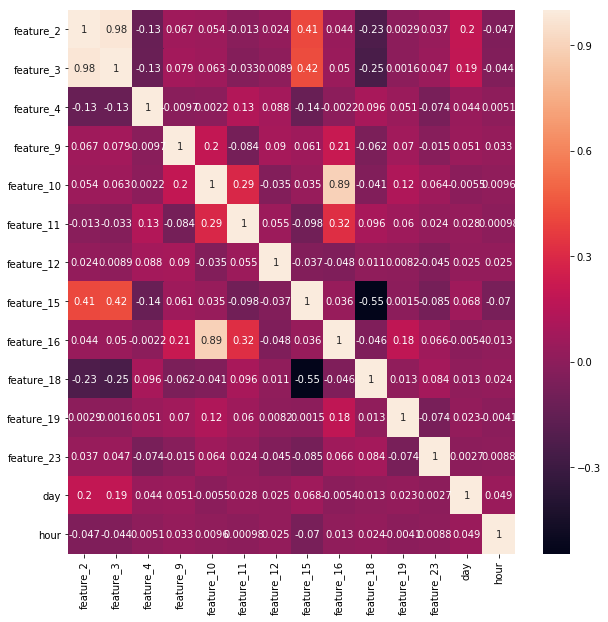

In [17]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
sns.heatmap(pear_corr_df, annot=True)

### heatmap insights:

    by pearson it looks like (16 and 10) and (2 and 3) are highly correlated. we might want to pick one from each   couple.

    15 is 0.4 correlated to (2 and 3)
    18 is -0.55 correlated to 15

### remove highly correlated numeric columsn from the list

In [22]:
rmv = ['feature_2','feature_10']
num_col = [i for i in num_col if i not in rmv]

### plot histograhms of the numeric columns

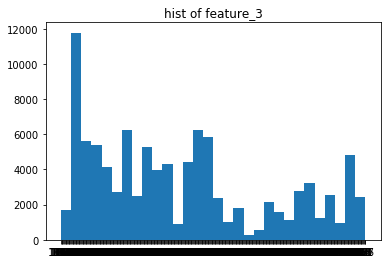

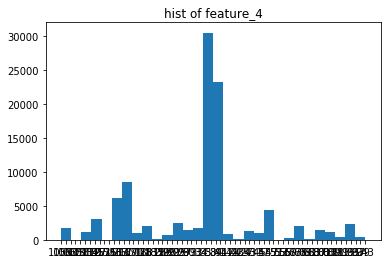

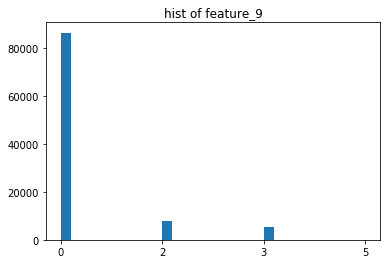

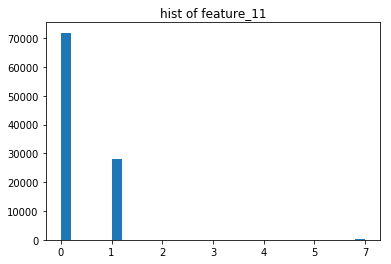

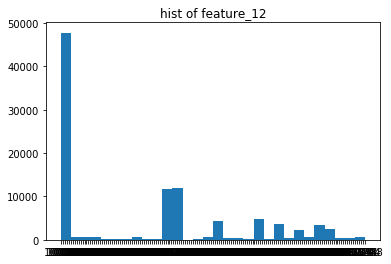

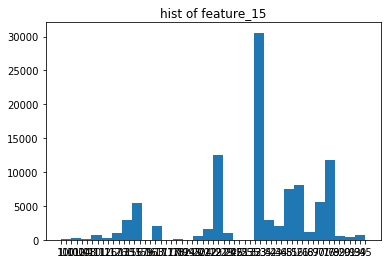

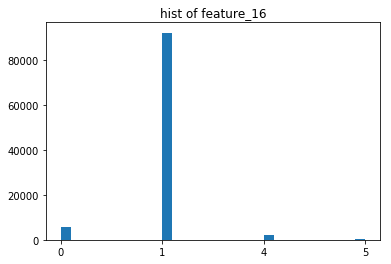

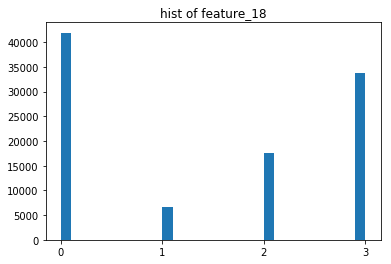

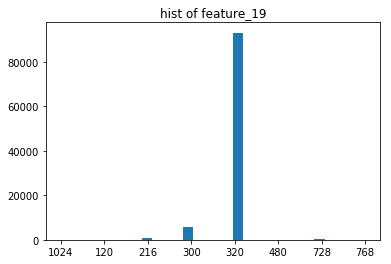

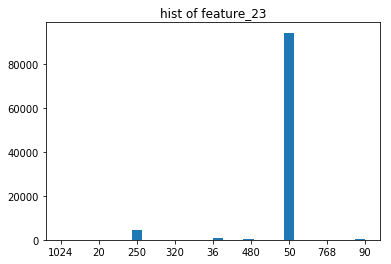

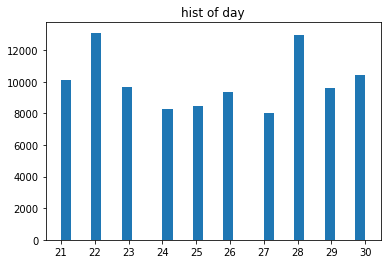

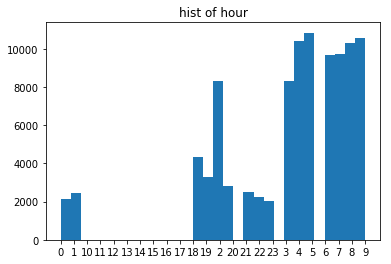

In [24]:
#TODO : plot a nice hist of all numeric, we might find some cats in there.
for c in num_col:
    plt.hist(df.select(c).limit(100000).toPandas(),bins=30)
    plt.title('hist of {}'.format(c))
    plt.show()

### hist insights : 
1. cat features found - 9,11,16,18,19,23
2. 19 and 23 looks like ad size.
3. we have data from each day but not for all hours.

In [23]:
num_to_rmv = ["feature_{}".format(i) for i in [9,11,18,16,19,23]]
num_col = [c for c in num_col if c not in num_to_rmv]

### bubble plot

In [99]:
dfp = df.limit(100000).select(['feature_17','feature_23','feature_18','feature_15','label']).toPandas()

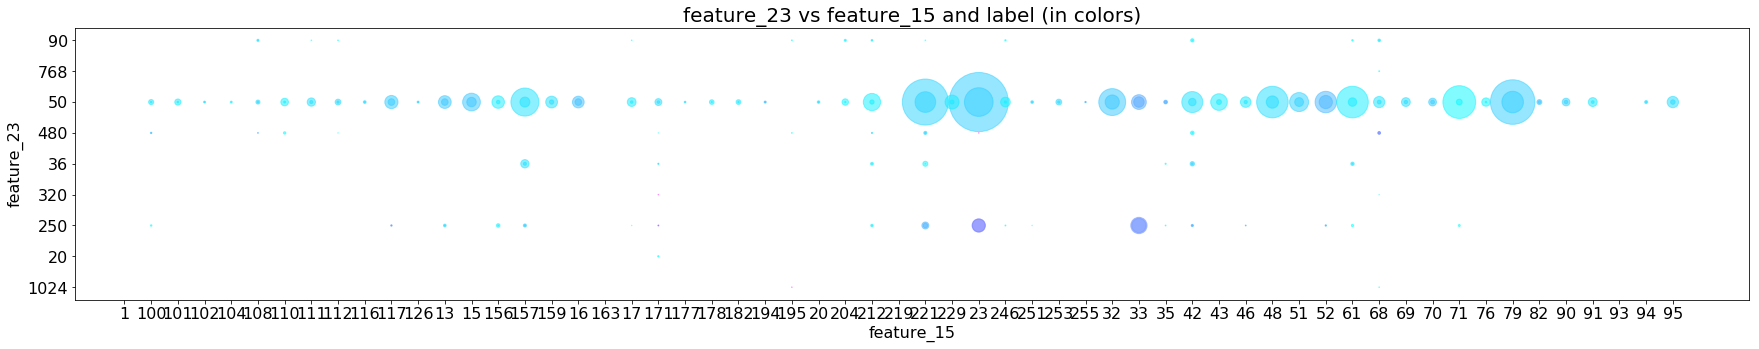

In [107]:
bubble_plot(dfp,x='feature_15',y='feature_23',z_boolean='label',figsize=(30, 5))

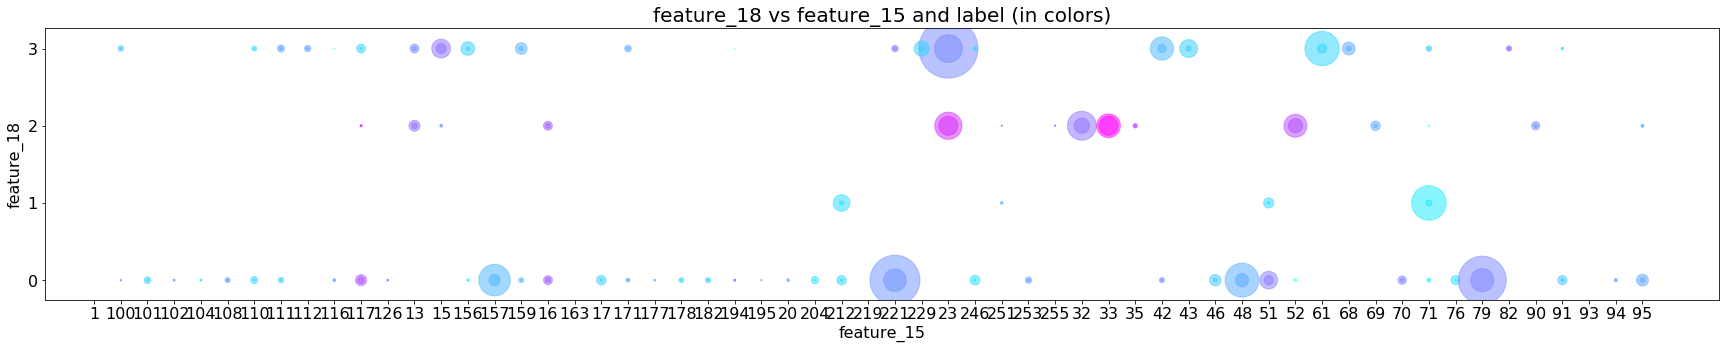

In [110]:
bubble_plot(dfp,x='feature_15',y='feature_18',z_boolean='label',figsize=(30, 5))#

### bubble plot insight:

    higher values of label will fall in feature_23=250 and feature_15 =(33,23)
    higher values of label will fall in feature_18=2 and feature_15=(23,33,52)

### now we will examine the distribution of the categorical features. what interest us is the number of distinct values and thier distribution.

In [28]:
num_of_distincts=[]
for c in cat_col:
   num_of_distincts.append(df.agg(F.countDistinct(c)).collect()[0][0])


cat_distinct_pd = pd.DataFrame([num_of_distincts],columns=cat_col,index=['#distincts'])


### number of distinct

In [29]:
cat_distinct_pd

,feature_5,feature_6,feature_7,feature_8,feature_13,feature_14,feature_17,feature_20,feature_21,feature_9,feature_11,feature_18,feature_16,feature_19,feature_23
#distincts,3423,4886,28,6375,304,1634134,4266,23,504238,4,7,4,5,8,9


### covert int type to string in cat_cols

In [26]:
df.select(cat_col).dtypes
for f in [t[0] for t in df.select(cat_col).dtypes if t[1]=='int']:
    df = df.withColumn(f,F.col(f).cast(StringType()))


### and their distribution (top 20 by percentage)

In [27]:
schema = StructType([StructField("rank", IntegerType())])
cat_dist = spark.createDataFrame([[i] for i in range(1,21)],schema=schema)       
    
for c in cat_col:
    
    temp = df.groupBy(c).count().withColumn('percent_'+c,F.col('count')/df.count())
    window = Window.orderBy(temp["percent_"+c].desc())
    temp = temp.withColumn("rank",F.rank().over(window))
    cat_dist = cat_dist.join(temp,on="rank")


cat_dist_pd = cat_dist.toPandas()
cat_dist_pd.sort_values(by='rank')

,rank,feature_5,count,percent_feature_5,feature_6,count,percent_feature_6,feature_7,count,percent_feature_7,...,percent_feature_18,feature_16,count,percent_feature_16,feature_19,count,percent_feature_19,feature_23,count,percent_feature_23
0,1,85f751fd192,1458198,0.360934,ecad2386ff,2581867,0.639066,07d7df22v8n,2614925,0.647248,...,0.419066,1,3727633,0.922667,320,3768694,0.932830,50,3811472,0.943418
3,2,1fbe01fe192,649362,0.160731,92f5800bff,155433,0.038473,0f2161f8v8n,955212,0.236435,...,0.337802,0,222258,0.055013,300,232935,0.057656,250,179933,0.044537
1,3,e151e245192,263095,0.065121,e2fcccd2ff,112470,0.027839,cef3e649v8n,173250,0.042883,...,0.175757,4,77245,0.019120,216,30022,0.007431,36,30022,0.007431
2,4,d9750ee7192,96714,0.023939,febd1138ff,75931,0.018794,8ded1f7av8n,146243,0.036198,...,0.067374,5,12925,0.003199,728,7494,0.001855,480,10224,0.002531


### categorical strategy:

all features but 14 are centered across few values, and (21 19 23) are exceptionaly centered over one value.

we will transform feature_14 into a smaller space using the hashing trick.

for the rest we will replace values that appear less then 1% with "other" and one hot encode the result
values that dont appear much will push the model towards overfitting.

### adding new columns with replcaing the values that have a frequency of less then 1% with "other"

In [30]:
for feature in cat_col:
    
    values_to_keep = cat_dist_pd[cat_dist_pd["percent_"+feature]>0.01][feature].tolist()
    
    df = df.withColumn(feature+"_replaced",F.when(F.col(feature).isin(values_to_keep),F.col(feature)).otherwise(F.lit("other")))


### lets examine the new columns distribution

In [36]:
schema = StructType([StructField("rank", IntegerType())])
cat_dist_after_replacement = spark.createDataFrame([[i] for i in range(1,10)],schema=schema)       
    
cat_col.remove('feature_14')
for c in [i+"_replaced" for i in cat_col]:
    
    temp = df.groupBy(c).count().withColumn('percent_'+c,F.col('count')/df.count())
    window = Window.orderBy(temp["percent_"+c].desc())
    temp = temp.withColumn("rank",F.rank().over(window))
    #temp.where(temp.rank<=20).show()
    cat_dist_after_replacement = cat_dist_after_replacement.join(temp,on="rank",how='left')


cat_dist_pd_after_replacement = cat_dist_after_replacement.toPandas()
cat_dist_pd_after_replacement.sort_values(by='rank')

,rank,feature_5_replaced,count,percent_feature_5_replaced,feature_6_replaced,count,percent_feature_6_replaced,feature_7_replaced,count,percent_feature_7_replaced,...,percent_feature_18_replaced,feature_16_replaced,count,percent_feature_16_replaced,feature_19_replaced,count,percent_feature_19_replaced,feature_23_replaced,count,percent_feature_23_replaced
0,1,other,1572696.0,0.389275,ecad2386ff,2581867.0,0.639066,07d7df22v8n,2614925.0,0.647248,...,0.419066,1,3727633.0,0.922667,320,3768694.0,0.932830,50,3811472.0,0.943418
8,2,85f751fd192,1458198.0,0.360934,other,1114364.0,0.275828,0f2161f8v8n,955212.0,0.236435,...,0.337802,0,222258.0,0.055013,300,232935.0,0.057656,250,179933.0,0.044537
2,3,1fbe01fe192,649362.0,0.160731,92f5800bff,155433.0,0.038473,cef3e649v8n,173250.0,0.042883,...,0.175757,4,77245.0,0.019120,other,38436.0,0.009514,other,48660.0,0.012044
5,4,e151e245192,263095.0,0.065121,e2fcccd2ff,112470.0,0.027839,other,150435.0,0.037236,...,0.067374,other,12929.0,0.003200,None,NaN,NaN,None,NaN,NaN
3,5,d9750ee7192,96714.0,0.023939,febd1138ff,75931.0,0.018794,8ded1f7av8n,146243.0,0.036198,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
1,6,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
7,7,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
6,8,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
4,9,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN


### defien a new categorical columns list for modeling

In [41]:
cat_cols_replaced = [i+"_replaced" for i in cat_col]
cat_cols_replaced

# pre-proccessing pipeline

stages for pipeline will include for each categorical column a string indexer and one hot encoding.
feature 14 will be mapped using hash as mentioned above.
ending with a vector assembler.

In [42]:
stages = []

for c in cat_cols_replaced:
    stringIndexer = StringIndexer(inputCol = c, outputCol = c + '_indexed')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[c + "_encoded"])
    stages += [stringIndexer, encoder]


hasher = FeatureHasher(inputCols=["feature_14"], outputCol="feature_14_hashed",numFeatures=5)
stages+=[hasher]


assemblerInputs = [c + "_encoded" for c in cat_cols_replaced] + num_col+['feature_14_hashed']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### examine that the pre proccessing pipeline works as expected 

In [43]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)


df_transformed.printSchema()

root
 |-- id: string (nullable = true)
 |-- feature_1: string (nullable = true)
 |-- feature_2: integer (nullable = true)
 |-- feature_3: integer (nullable = true)
 |-- feature_4: integer (nullable = true)
 |-- feature_5: string (nullable = true)
 |-- feature_6: string (nullable = true)
 |-- feature_7: string (nullable = true)
 |-- feature_8: string (nullable = true)
 |-- feature_9: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- feature_10: integer (nullable = true)
 |-- feature_11: string (nullable = true)
 |-- feature_12: integer (nullable = true)
 |-- feature_13: string (nullable = true)
 |-- feature_14: string (nullable = true)
 |-- feature_15: integer (nullable = true)
 |-- feature_16: string (nullable = true)
 |-- feature_17: string (nullable = true)
 |-- feature_18: string (nullable = true)
 |-- feature_19: string (nullable = true)
 |-- feature_20: string (nullable = true)
 |-- feature_21: string (nullable = true)
 |-- feature_23: string (nullable = true)
 |

### train test split by a ratio of 70 - 30

In [42]:
train, test = df.randomSplit([0.7, 0.3])
# double check that statistics works and we have the same proportion of label values
train.groupBy('label').count().withColumn('percent',F.col('count')/train.count()).show()
test.groupBy('label').count().withColumn('percent',F.col('count')/test.count()).show()


+-----+-------+-------------------+
|label|  count|            percent|
+-----+-------+-------------------+
|    1| 479361|0.16951441520194863|
|    0|2348487| 0.8304855847980513|
+-----+-------+-------------------+

+-----+-------+-------------------+
|label|  count|            percent|
+-----+-------+-------------------+
|    1| 206254|0.17014610420411527|
|    0|1005963| 0.8298538957958848|
+-----+-------+-------------------+



### set an evaluation function for modeling binary classification

In [43]:
def summary_report(y,pred,write=False,path=''):
    '''
    
    this function will provide a performance report for a binary classifier:
    
    param : y list of labels.
    param : pred listof predictions.
    param : write boolean if to save plots.
    param : path string path where to save the plots to.
    
    '''
    
    
    ''' PRECISION RECALL CURVE '''
    prec, rec, thresholds_new = precision_recall_curve(y, pred)
    
    #fig = plt.figure(figsize=(10,10))    
    plt.plot(rec, prec, lw=2, color='red',label='auc = {}'.format(auc(rec, prec))) 
    plt.legend(loc="upper right")
    plt.xlabel('recall',fontsize=15)
    plt.ylabel('precision',fontsize=15)
    plt.title('recall precision curve',fontsize=15)
    if write:
        plt.savefig('{}/precision_recall_graph.png'.format(path))
    plt.show()


    ''' CALIBRATION CURVE '''
    fraction_of_positives, mean_predicted_value = calibration_curve(y, pred, n_bins=20)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.plot(fraction_of_positives,mean_predicted_value , "s-")
    plt.legend(loc="upper right")
    plt.xlabel('fraction of positive',fontsize=15)
    plt.ylabel('mean predicted value',fontsize=15)
    plt.title('calibration curve',fontsize=15)
    if write:
        plt.savefig('{}/calibration_curve.png'.format(path))
    plt.show()
   
    
    ''' PRED HIST '''
    plt.hist(pred,bins=50)
    plt.legend(loc="upper right")
    plt.xlabel('prediction',fontsize=15)
    plt.ylabel('count',fontsize=15)
    plt.title('prediction histograhm',fontsize=15)
    if write:
        plt.savefig('{}/prediction_hist.png'.format(path))
    plt.show()
    
     
    ''' AUC '''
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    if write:
        plt.savefig('{}/roc_auc_curve.png'.format(path))
    plt.show()

# modeling and evaluation 

### define models: logistic regression, random forest, gradient boosted trees

In [44]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gbt = GBTClassifier(subsamplingRate=0.5, maxIter=10)

### we will now iterate through those three models.
### performing cross validation with 3 folds evaluated by auc of roc
### and printing a summary report containing hist of predictoins, roc,pr curve, and calibration curve.


### evaluate_model function will train cross validated models for each of the params combination, and return the best model

In [45]:
def evaluate_model(model,param_grid,stages=stages):
    '''
    
    this function will train a model and return a performance report.
    
    param model : spark mllib model.
    param : param_grid spark ParamGribBuiler.
    param : stages list of preproccessing stages.
    
    the function plots the following : precision recall curve, prediction hist, roc curve, calibration curve.
    
    '''
    
    modelling_stages = stages+[model]
        
    pipeline = Pipeline(stages = modelling_stages)

    # default metric is auc of roc
    evaluator=BinaryClassificationEvaluator()
    

    
    cv = CrossValidator(      estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3)
    
    
    # train cv
    cv_model = cv.fit(train)
    
    #  use resulted model on test set and plot auc
    res = cv_model.transform(test)
    print('Test set areaUnderROC: ' + str(evaluator.evaluate(res)))
    
    
    # get predictions and y as lists for "summary_report" function
    second_element_udf= F.udf(lambda v : float(v[1]) ,FloatType())
    pred_list = res.select(second_element_udf('probability')).rdd.flatMap(lambda x : x).collect()
    y_list = test.select('label').rdd.flatMap(lambda x : x).collect()
    
    summary_report(y_list,pred_list)
        
 

### logistic regression

Test set areaUnderROC: 0.6734931348143262


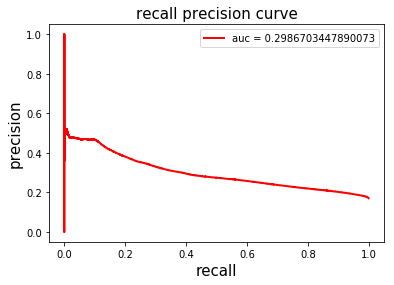

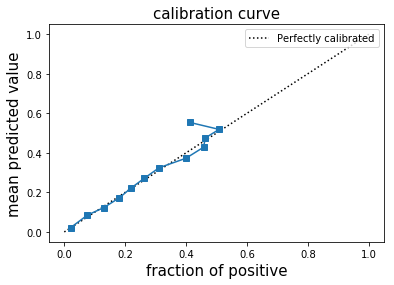

No handles with labels found to put in legend.


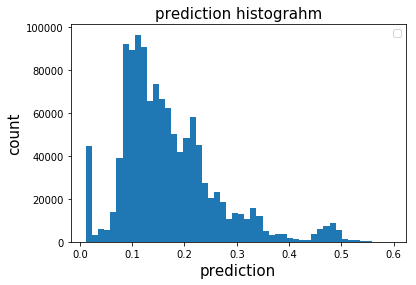

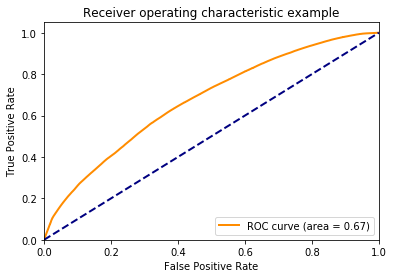

In [46]:
lr_param = (ParamGridBuilder()
             .addGrid(lr.maxIter, [10,20,30])
             .build())


evaluate_model(lr,lr_param)

### random forest

Test set areaUnderROC: 0.6734931348143264


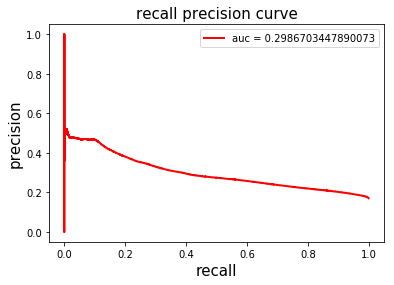

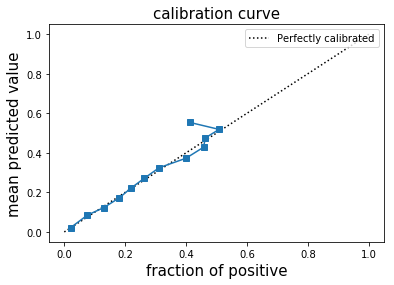

No handles with labels found to put in legend.


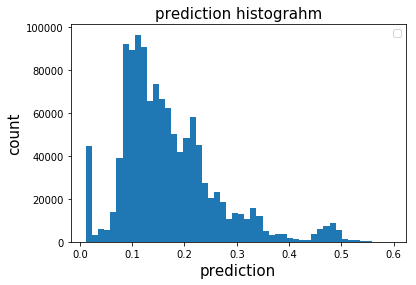

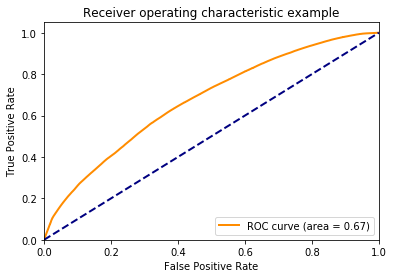

Test set areaUnderROC: 0.6997104128173688


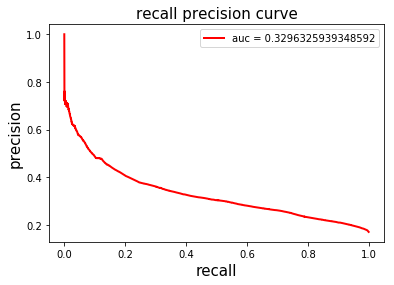

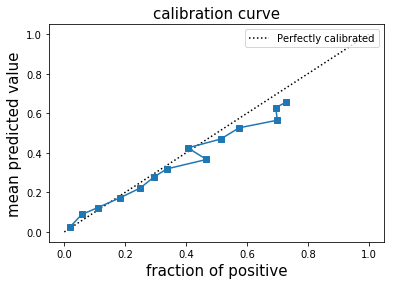

No handles with labels found to put in legend.


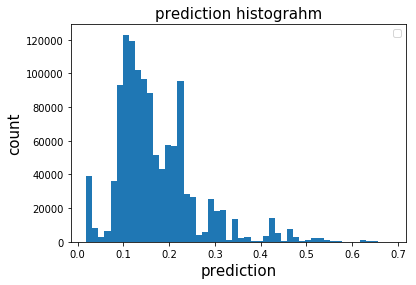

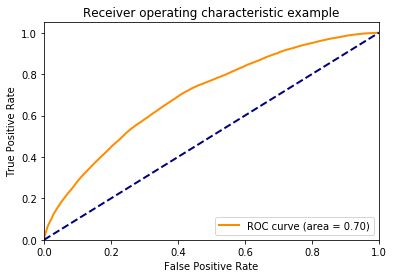

In [47]:
evaluate_model(lr,lr_param)

rf_param = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [4,6,8])
             .build())

evaluate_model(rf,rf_param)

### gradint boosted trees

Test set areaUnderROC: 0.67781274856969


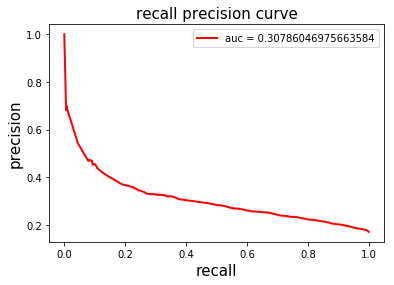

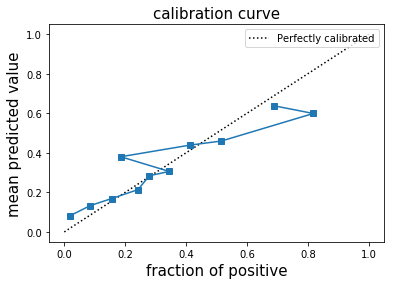

No handles with labels found to put in legend.


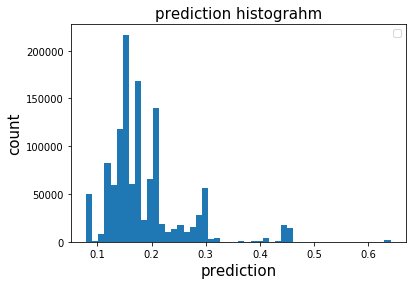

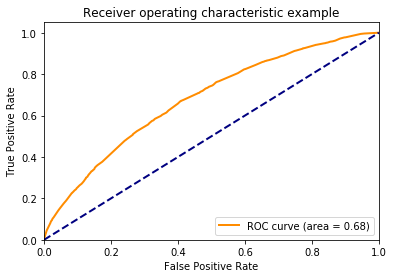

In [48]:
gbt_param = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3])
             .build())

evaluate_model(gbt,gbt_param)

### lets try xgboost using pandas and explain using shap

### define two functions, one trains a model using stratified cv and the other for importance plotting

In [86]:
def importance(model,importance_type='gain',write=False,path=""):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    xgb.plot_importance(model, max_num_features=30, height=0.8, ax=ax,importance_type=importance_type)
    if write:
       plt.savefig('{}/importance.png'.format(path))

In [76]:
def train_cv_model(X,Y):
    '''
    train cv xgb model and return auc vectors for test and train
    
    '''
    skf = StratifiedKFold(n_splits=3,shuffle=True)


    auc=[]
    auc_train=[]
    
    for train_index, test_index in skf.split(X, Y):
        print(train_index)
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        
        model = xgb.XGBClassifier(objective ='binary:logistic',
                                 colsample_bytree=1,
                                 learning_rate=0.3,
                                 max_depth=6,
                                 subsample=1,
                                 n_estimators=30,
                                 base_score=0.16,
                                 seed=2,
                                 verbosity=10
                                 )
    
    
        eval_result={}
        eval_set = [(X_train, y_train,'train'),(X_test, y_test,'test')]
        
        model.fit(X_train, y_train,verbose=True, eval_set=eval_set, eval_metric="auc",
                   callbacks=[xgb.callback.record_evaluation(eval_result),xgb.callback.early_stop(3)] 
                         )
            
        
        
        preds_test =  model.predict_proba(X_test)[:,1]
        roc_auc_score(y_test, preds_test)
        
        preds_train =  model.predict_proba(X_train)[:,1]
        roc_auc_score(y_train, preds_train)
        
        auc.append(roc_auc_score(y_test, preds_test) )
        auc_train.append(roc_auc_score(y_train, preds_train) )
    
    
    #print("test mean: {0}  train mean: {1}".format(np.mean(auc),np.mean(auc_train)))
    return {"test_auc":auc,"train_auc":auc_train,"model":model}

### split df transformed into train and test

In [63]:
model_cols = [c + "_indexed" for c in cat_cols_replaced] + num_col +['label']

train_transformed, test_transformed = df_transformed.select(model_cols).randomSplit([0.7, 0.3])

### sample data into pandas df

In [66]:
trainp = train_transformed.limit(100000).toPandas()
testp = test_transformed.limit(100000).toPandas()

### train an xgboost model cross validated

In [77]:
x_cols = [c for c in model_cols if c not in ['label']]
res_xgb = train_cv_model(trainp[x_cols],trainp[['label']])

[    0     1     2 ... 99996 99997 99999]
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 3 rounds.
[0]	validation_0-auc:0.673656	validation_1-auc:0.67028


/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passe

[1]	validation_0-auc:0.679726	validation_1-auc:0.675874
[2]	validation_0-auc:0.683929	validation_1-auc:0.679294
[3]	validation_0-auc:0.688089	validation_1-auc:0.683678
[4]	validation_0-auc:0.691729	validation_1-auc:0.685253
[5]	validation_0-auc:0.696886	validation_1-auc:0.689709
[6]	validation_0-auc:0.700328	validation_1-auc:0.6921
[7]	validation_0-auc:0.701312	validation_1-auc:0.692673
[8]	validation_0-auc:0.707795	validation_1-auc:0.697966
[9]	validation_0-auc:0.709777	validation_1-auc:0.699694
[10]	validation_0-auc:0.712175	validation_1-auc:0.700997
[11]	validation_0-auc:0.714454	validation_1-auc:0.702556
[12]	validation_0-auc:0.715128	validation_1-auc:0.70293
[13]	validation_0-auc:0.715868	validation_1-auc:0.703396
[14]	validation_0-auc:0.718639	validation_1-auc:0.704666
[15]	validation_0-auc:0.721594	validation_1-auc:0.705177
[16]	validation_0-auc:0.723409	validation_1-auc:0.705405
[17]	validation_0-auc:0.72483	validation_1-auc:0.706282
[18]	validation_0-auc:0.726597	validation_1-

/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passe

[2]	validation_0-auc:0.692213	validation_1-auc:0.676643
[3]	validation_0-auc:0.696667	validation_1-auc:0.681459
[4]	validation_0-auc:0.701766	validation_1-auc:0.686394
[5]	validation_0-auc:0.70425	validation_1-auc:0.687426
[6]	validation_0-auc:0.707803	validation_1-auc:0.689891
[7]	validation_0-auc:0.708888	validation_1-auc:0.690443
[8]	validation_0-auc:0.7118	validation_1-auc:0.692725
[9]	validation_0-auc:0.713405	validation_1-auc:0.693147
[10]	validation_0-auc:0.716337	validation_1-auc:0.694022
[11]	validation_0-auc:0.718449	validation_1-auc:0.694631
[12]	validation_0-auc:0.719247	validation_1-auc:0.695059
[13]	validation_0-auc:0.72101	validation_1-auc:0.696048
[14]	validation_0-auc:0.722439	validation_1-auc:0.695969
[15]	validation_0-auc:0.72431	validation_1-auc:0.696002
[16]	validation_0-auc:0.725315	validation_1-auc:0.696783
[17]	validation_0-auc:0.727506	validation_1-auc:0.697213
[18]	validation_0-auc:0.728903	validation_1-auc:0.697327
[19]	validation_0-auc:0.731487	validation_1-

/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amir/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passe

[2]	validation_0-auc:0.691305	validation_1-auc:0.679231
[3]	validation_0-auc:0.695448	validation_1-auc:0.681286
[4]	validation_0-auc:0.701735	validation_1-auc:0.685934
[5]	validation_0-auc:0.705602	validation_1-auc:0.687815
[6]	validation_0-auc:0.706789	validation_1-auc:0.68849
[7]	validation_0-auc:0.709983	validation_1-auc:0.690039
[8]	validation_0-auc:0.712936	validation_1-auc:0.692799
[9]	validation_0-auc:0.716099	validation_1-auc:0.694344
[10]	validation_0-auc:0.717091	validation_1-auc:0.694474
[11]	validation_0-auc:0.718939	validation_1-auc:0.695218
[12]	validation_0-auc:0.721151	validation_1-auc:0.695885
[13]	validation_0-auc:0.723973	validation_1-auc:0.696801
[14]	validation_0-auc:0.726113	validation_1-auc:0.6978
[15]	validation_0-auc:0.727273	validation_1-auc:0.698315
[16]	validation_0-auc:0.727838	validation_1-auc:0.698271
[17]	validation_0-auc:0.728447	validation_1-auc:0.698511
[18]	validation_0-auc:0.732067	validation_1-auc:0.70044
[19]	validation_0-auc:0.732855	validation_1

### xgboost test auc

In [82]:
roc_auc_score(testp['label'],res_xgb['model'].predict_proba(testp[x_cols])[:,1])

0.7078284207106763

### xgboost importance plots

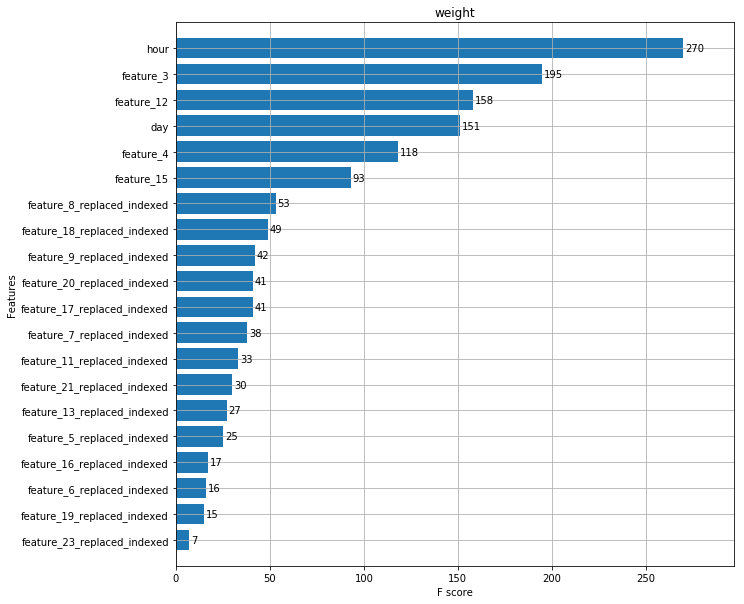

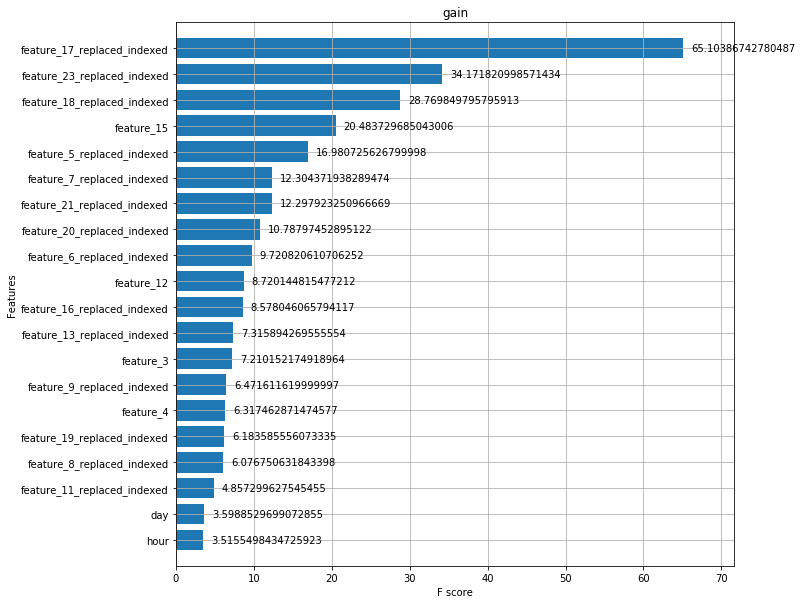

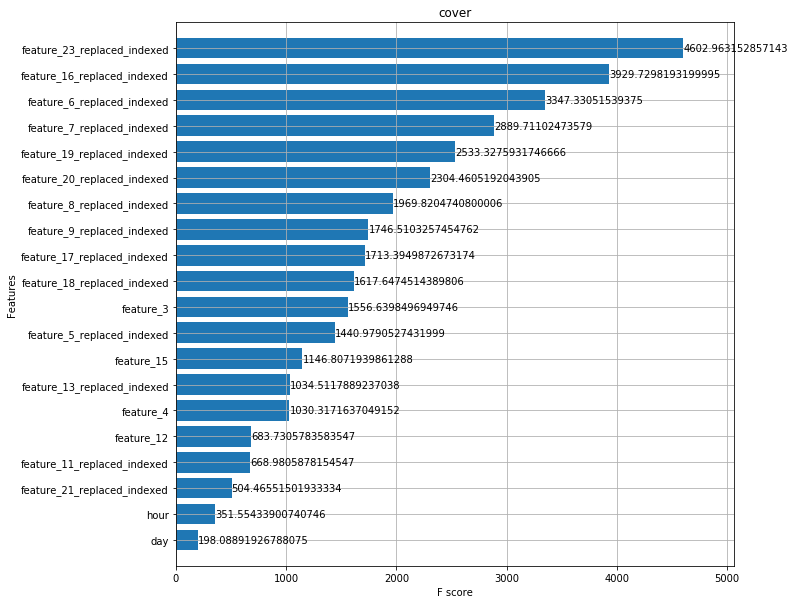

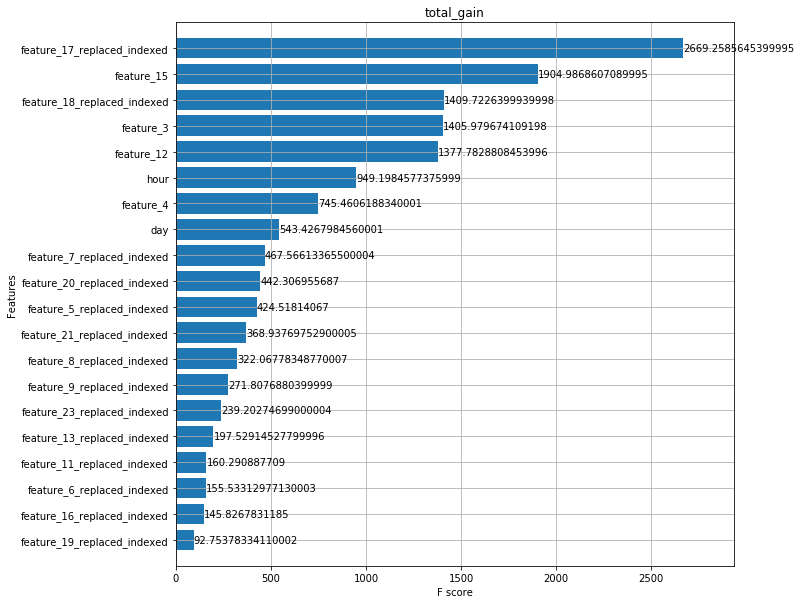

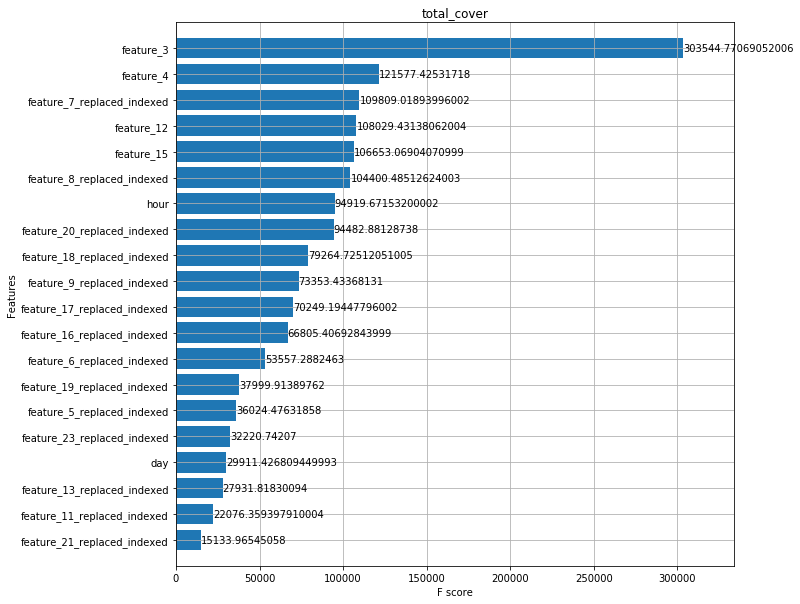

In [87]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for f in importance_types :
    importance(res_xgb['model'],importance_type=f)
    plt.title(f)

### importance plots insights:
    1. highest gain feature is 17, although it is not in the top covered.
    2. the gain drops rapidly meaning we do not have many strong features.
    3. I would examine further the top covered features to see what we can get out of them.

### calculate all shap values

In [83]:
shap_values = shap.TreeExplainer(res_xgb['model']).shap_values(testp[x_cols])



### plot aggregated shap plot

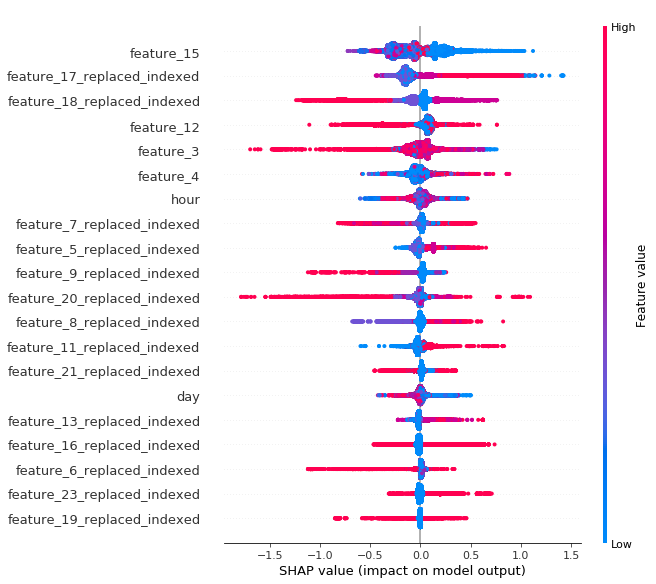

In [84]:
#fig = plt.figure(figsize=(20,10))

shap.summary_plot(shap_values, testp[x_cols],max_display=30,show=False)



### quick shap insights:
    1. features 4,8,day,11,9 are nicley splitted where high values correspond to higher predictions.
    2. there are feature interactions to examine.

### plot dependence shap plot

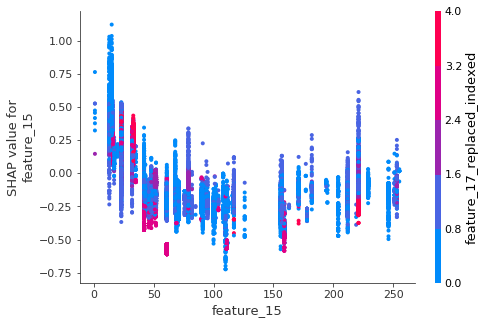

In [88]:
shap.dependence_plot("feature_15", shap_values, testp[x_cols])

### interaction insights:
    1. feature 15 has a parabola shape regarding its component to prediction
    2. interacting with feature 17: before value ~30 for feature 15, higher values for 17 will increase shap, while 
       after ~30 higher values for 17 will mean lower shap values for feaure 15.

# to conclude : the winning model among the spark models is random forest, it has the highest areas unsder both curves, and it is nicley caliberated.

# it is always fun to examine a new data set. I hope we will have the chance to meet again. thank you.

### more things I would have do:
    1. anomaly detection (maybe using isolation forest)
    2. feature normalization.
    3. feature selection for each model.
    4. more hyperparameter tunning and training deeper.
    5. sophisticated feature engineering.